# Opening the black box of Deep Neural Networks with Information

Replicating results of a paper by _Naftali Tishby_ and _Ravid Schwartz-Ziv_

## Information bottleneck

## Experimental setup

2 files are attached: 
- **information_process.py** contains methods for estimating mutual information. This code was made available by the authors of the paper: we claim no credit for it.
- **experimental_setup.py** contains our tools for setting up experiments 

In [1]:
import numpy as np
import torch.optim
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from experimental_setup import ZivInformationPlane, BufferedSequential, mutual_information_for_network_family

In [58]:
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

def experiment(base_network, X, y, 
               epochs=100, lr=.2, batch_size=101, 
               network_copies=1, 
               plot='dynamic', 
               activation_bins=np.linspace(-1,1,50)):
    loss = torch.nn.MSELoss()
    network_copies = [copy.deepcopy(base_network) for _ in range(network_copies)]
    solvers = [torch.optim.SGD(params=network.parameters(), lr=lr) for network in network_copies]
    infoplane = ZivInformationPlane(X, y, bins=activation_bins)
    
    if plot == 'dynamic' or plot == 'once':
        fig = plt.figure(figsize=(12,5))
        graph = fig.add_subplot(111)
        graph.set_xlabel('I(X;T)')
        graph.set_ylabel('I(Y;T)')
        
    if plot == 'once':
        mi_history = [[] for _ in range(base_network.n_buffers)]
    
    for epoch in tqdm(range(epochs)) if plot == 'once' else range(epochs):
        for network, solver in zip(network_copies, solvers):
            slice_ = np.random.permutation(range(len(X)))[:batch_size]
            X_batch = Variable(torch.from_numpy(X[slice_])).float()
            y_batch = Variable(torch.from_numpy(y[slice_, np.newaxis])).float()

            solver.zero_grad()
            pred_batch = network(X_batch)

            loss(pred_batch, y_batch).backward()
            solver.step()
        
        mi = mutual_information_for_network_family(infoplane, network_copies)
        
        if plot == 'dynamic':
            graph.scatter(*zip(*mi), s=10, c=np.linspace(0, 1, base_network.n_buffers), alpha=epoch/epochs)
            display.clear_output(wait=True)
            display.display(fig)
        elif plot == 'once':
            for history, new_point in zip(mi_history, mi):
                history.append(new_point)
        
    if plot == 'once':
        for history in mi_history:
            graph.plot(*zip(*history))
            
    return network_copies

## Data

Following in the footsteps of Tishby an Schwartz-Ziv's original experiment, we'll generate test data using a simple binary decision function with small Gaussian noise

In [48]:
X = np.random.randint(5, size=(1000, 12)) - 1
y = (np.mean(X, axis=1) + np.random.normal(scale=0.1, size=1000) > 0.7).astype(np.int)
Y = y.reshape(-1, 1)

## Warm up

In [49]:
layers = [
    nn.Linear(12, 5),
    nn.Tanh(),
    nn.Linear(5, 1),
    nn.Tanh()
    ]
buffer_mask = [False, True, False, True]
architecture = BufferedSequential(layers, buffer_mask)

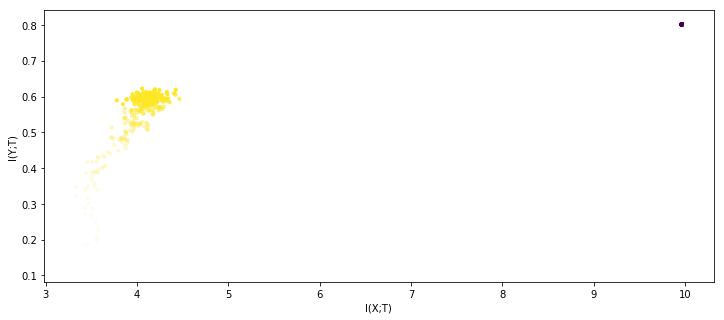

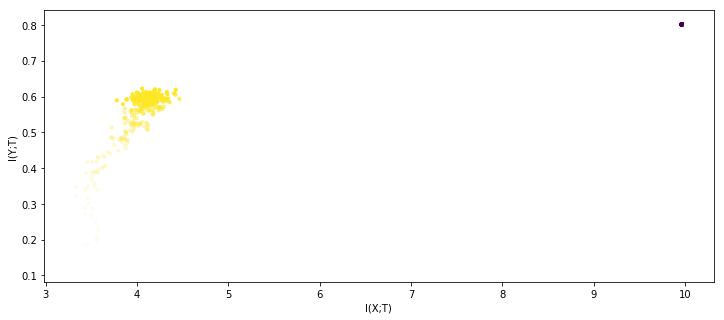

In [50]:
result_1layer = experiment(architecture, X, Y, epochs=300, network_copies=1, plot='dynamic')[0]

## Replication

The following neural network architecture is proposed in the original paper

In [51]:
layers = [
    nn.Linear(12, 10),
    nn.Tanh(),
    nn.Linear(10, 7),
    nn.Tanh(),
    nn.Linear(7, 5),
    nn.Tanh(),
    nn.Linear(5, 4),
    nn.Tanh(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 1),
    nn.Tanh()
    ]
buffer_mask = [False, True, False, True, False, True, False, True, False, True, False, True]
tishby_architecture = BufferedSequential(layers, buffer_mask)

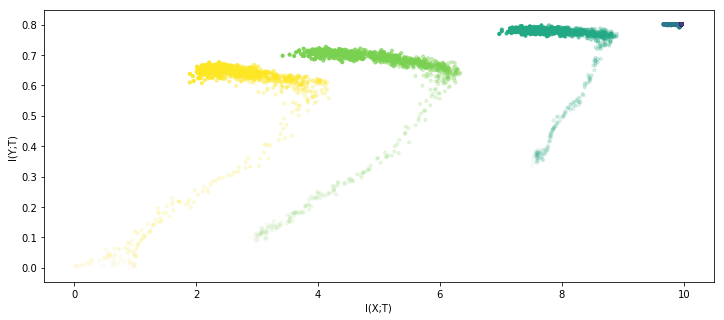

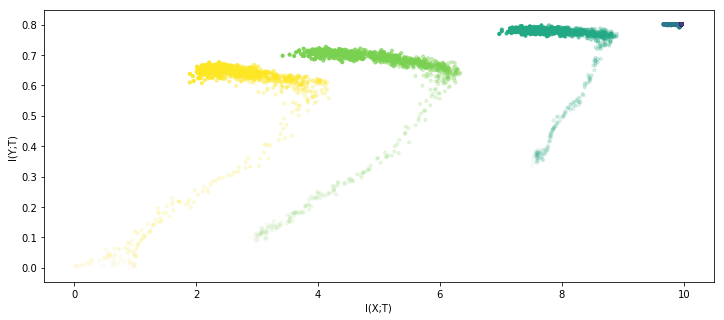

In [52]:
result_nets = experiment(tishby_architecture, X, Y, epochs=1000, network_copies=1, plot='dynamic')

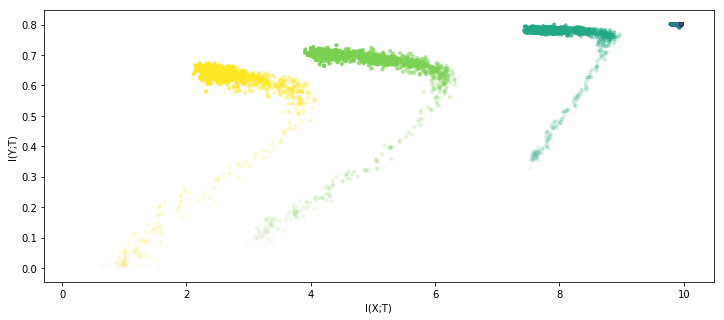

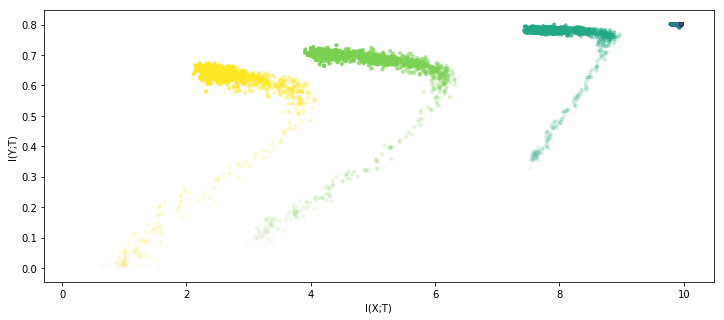

In [53]:
result_nets = experiment(tishby_architecture, X, Y, epochs=1000, network_copies=5, plot='dynamic')

This was a very close replica of the original experiment. Of course, it begs various "what if" questions (do the results hold if the conditions are changed?)

So...

## What if we?

* replace 0, 1 labels with -1, 1 (it should be better, as we're using hyperbolic tangent)

100%|██████████| 1000/1000 [11:46<00:00,  1.42it/s]


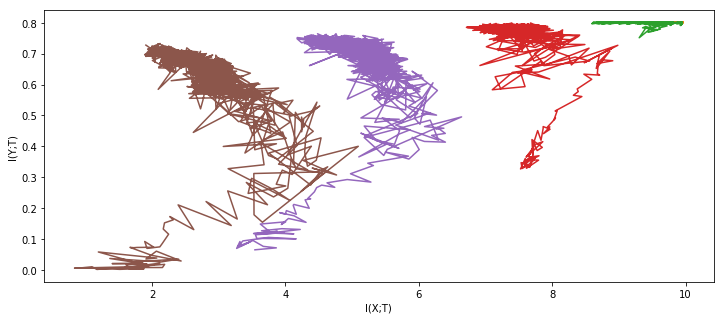

In [69]:
result_nets = experiment(tishby_architecture, X, Y * 2 - 1, epochs=1000, network_copies=5, plot='once')

* use a different activation function?

In [56]:
layers = [
    nn.Linear(12, 10),
    nn.Softsign(),
    nn.Linear(10, 7),
    nn.Softsign(),
    nn.Linear(7, 5),
    nn.Softsign(),
    nn.Linear(5, 4),
    nn.Softsign(),
    nn.Linear(4, 3),
    nn.Softsign(),
    nn.Linear(3, 1),
    nn.Softsign()
    ]
buffer_mask = [False, True, False, True, False, True, False, True, False, True, False, True]
sigmoid_architecture = BufferedSequential(layers, buffer_mask)

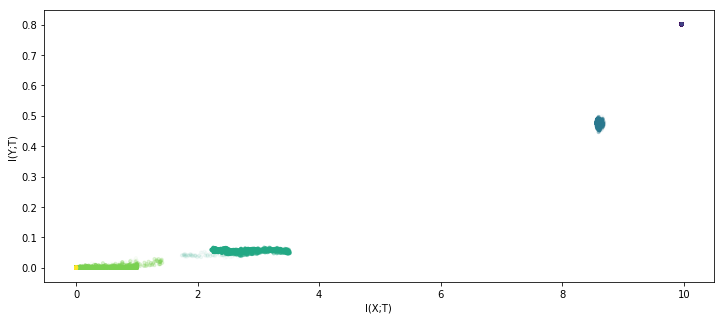

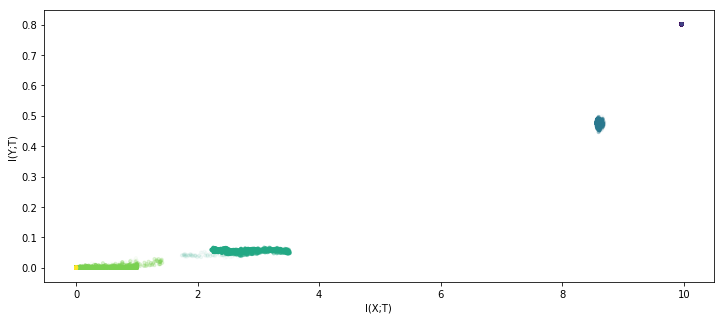

In [57]:
result_nets = experiment(sigmoid_architecture, X, Y, epochs=1000, network_copies=5, plot='dynamic')

OK, this looks like terrible architecture-problem fit. Mutual information between the last layer and Y doesn't improve in a 1000 epochs

* mix different activation functions?

In [67]:
layers = [
    nn.Linear(12, 10),
    nn.Softsign(),
    nn.Linear(10, 7),
    nn.Sigmoid(),
    nn.Linear(7, 5),
    nn.Softsign(),
    nn.Linear(5, 4),
    nn.Sigmoid(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 1),
    nn.Tanh()
    ]
buffer_mask = [False, True, False, True, False, True, False, True, False, True, False, True]
mixed_architecture = BufferedSequential(layers, buffer_mask)

100%|██████████| 5000/5000 [1:00:55<00:00,  1.37it/s]


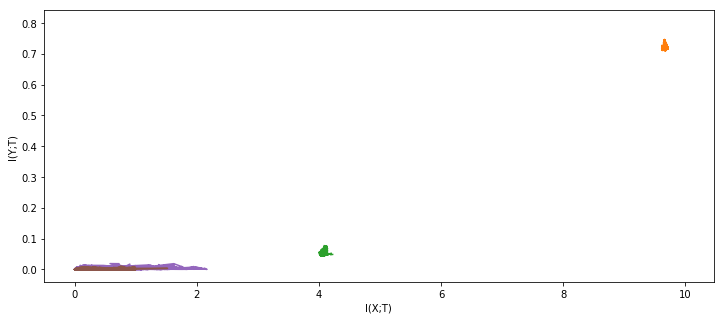

In [68]:
result_nets = experiment(mixed_architecture, X, Y, epochs=5000, network_copies=5, plot='once')

Again, this NN just doesn't work...

* try modelling a more complicated decision rule?

In [95]:
y_complicated = np.sum(X[:,2::2] * X[:,3::2]) - X[:,0] * X[:,0]
y_complicated = y_complicated + np.random.normal(size=1000, scale=0.2) > np.mean(y_complicated)
y_complicated = y_complicated * 2 - 1
Y_complicated = y_complicated.reshape(-1, 1)

100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


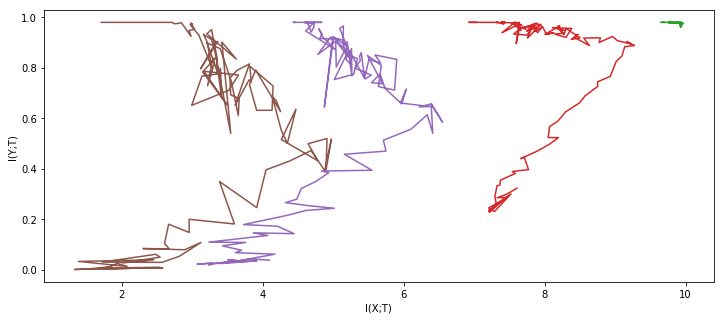

In [97]:
result_nets = experiment(tishby_architecture, X, Y_complicated, epochs=200, network_copies=5, plot='once')

## Bonus: mutual information stopping criterion

In [ ]:
from tqdm import tqdm

def fit(network, 
        X, 
        y, 
        epochs=10, 
        epoch_length=10, 
        mi_tol=0.1, 
        beta = 1, 
        lr=.2, 
        batch_size=101, 
        activation_bins=np.linspace(-1,1,50), 
        loss = torch.nn.MSELoss()):
    """Use the mutual information of the last layer 
       as a stopping criterion when fitting a neural net"""
    
    solver = torch.optim.SGD(params=network.parameters(), lr=lr)
    infoplane = ZivInformationPlane(X, y, bins=activation_bins)
    mi_last = 10e-20
    
    for epoch in tqdm(range(epochs)):
        for _ in range(epoch_length):
            slice_ = np.random.permutation(range(len(X)))[:batch_size]
            X_batch = Variable(torch.from_numpy(X[slice_])).float()
            y_batch = Variable(torch.from_numpy(y[slice_, np.newaxis])).float()

            solver.zero_grad()
            pred_batch = network(X_batch)

            loss(pred_batch, y_batch).backward()
            solver.step()
        
        mi_x, mi_y = mutual_information_for_network_family(infoplane, network_copies)[-1]
        mi = mi_y - beta * mi_x 
        if mi - mi_last < tol * mi_last:
            break

## Conclusions

* Original experiment **replicated successfuly**
* The claim that optimization of neural networks always decomposes strictly into 2 phases **doesn't hold for all experiments**. The last experiment suggests that the pases alternate back and forth more than once

We have also introduced:
* An improvement of the mutual information estimator with several neural networks
* A new stopping criterion for neural network optimization